In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import argparse
import pickle
import os
from torchvision import transforms
from build_vocab import Vocabulary
from PIL import Image
import pandas as pd

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [5]:
def read_mat_file(matfile):
    import scipy.io as sio
    
    mat_contents = sio.loadmat(matfile)
    data = mat_contents["data"]
    return data[0,0][7]

def load_matfile(mat_img,transform):
    
    if transform is not None:
        image = transform(mat_img).unsqueeze(0)

    return image

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

In [7]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        print(self.linear)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            #print(hiddens.shape)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            #print(predicted.shape)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [9]:
# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

In [10]:
# Load vocabulary wrapper
with open('data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
    
vocab.idx2word[1]
vocab.word2idx["<end>"]

2

In [11]:
encoder = EncoderCNN(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(256, 512, len(vocab), 1)
encoder = encoder.to(device)
decoder = decoder.to(device)

Linear(in_features=2048, out_features=256, bias=True)


In [12]:
# Load the trained model parameters
encoder.load_state_dict(torch.load('models/encoder-5-3000.pkl'))
decoder.load_state_dict(torch.load('models/decoder-5-3000.pkl'))
decoder

DecoderRNN(
  (embed): Embedding(9956, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9956, bias=True)
)

In [13]:
# Prepare an image
image_path = "png/example.png"
image = load_image(image_path, transform)
image_tensor = image.to(device)

_image = mpimg.imread(image_path)
#plt.imshow(_image)

In [14]:
# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

In [15]:
# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

<start> a group of giraffes standing next to each other . <end>


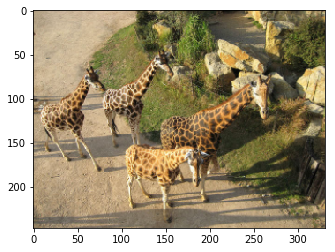

In [16]:
# Print out the image and the generated caption
print (sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image))

In [17]:
show_tell_df = pd.DataFrame()

images = "./imgs/"
#images = "/home/pramod/Downloads/datasets/image_caption/iapr_tc_12/"

count = 0

for img in os.listdir(images):
    if os.path.splitext(img)[1] == '.png' or os.path.splitext(img)[1] =='.jpeg' or os.path.splitext(img)[1] =='.jpg':
        #print(img.split()[0])
        image = load_image(images+img, transform)
        image_tensor = image.to(device)
        feature = encoder(image_tensor)
        sampled_ids = decoder.sample(feature)
        sampled_ids = sampled_ids[0].cpu().numpy()
        # Convert word_ids to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            sampled_caption.append(word)
            if word == '<end>':
                break
        sentence = ' '.join(sampled_caption)
        #_image = mpimg.imread("./imgs/"+img)
        #plt.imshow(_image)

        show_tell_df = show_tell_df.append(
            pd.DataFrame({'img':img,'show_tell':sentence},index=[0]),ignore_index=True)
        
        if count % 5 == 0:
            print(image_tensor.size())
            print(sentence)
        
        count += 1
        #_image = mpimg.imread("./imgs/"+img)
        #plt.figure()
        #plt.title(sentence)
        #plt.imshow(_image)

torch.Size([1, 3, 224, 224])
<start> a street scene with a traffic light and a street sign . <end>
torch.Size([1, 3, 224, 224])
<start> a dog sitting on a bench next to a bike . <end>
torch.Size([1, 3, 224, 224])
<start> a train is traveling down a track next to a building . <end>
torch.Size([1, 3, 224, 224])
<start> a computer monitor sitting on a desk next to a keyboard . <end>
torch.Size([1, 3, 224, 224])
<start> a zebra is standing in front of a building . <end>


In [18]:
matfile = '/home/pramod/Downloads/datasets/image_caption/labelme/data_for_image_caption.mat'

In [19]:
img_list = read_mat_file(matfile)
print(len(img_list))

1


In [26]:
len(img_list[0])

3825

In [29]:
show_tell_df = pd.DataFrame()
count = 0

for i in range(len(img_list[0])):

    image = load_matfile(img_list[0][i], transform)
    image_tensor = image.to(device)
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    #_image = mpimg.imread("./imgs/"+img)
    #plt.imshow(_image)

    show_tell_df = show_tell_df.append(
        pd.DataFrame({'img':i,'show_tell':sentence},index=[0]),ignore_index=True)

    if count % 500== 0:
        print(i)
        print(image_tensor.size())
        print(sentence)

    count += 1

0
torch.Size([1, 3, 224, 224])
<start> a room with a table and a table <end>
500
torch.Size([1, 3, 224, 224])
<start> a desk with a computer monitor and a keyboard <end>
1000
torch.Size([1, 3, 224, 224])
<start> a man is standing in front of a building . <end>
1500
torch.Size([1, 3, 224, 224])
<start> a desk with a laptop and a monitor on it . <end>
2000
torch.Size([1, 3, 224, 224])
<start> a desk with a laptop and a monitor on it . <end>
2500
torch.Size([1, 3, 224, 224])
<start> a city street with a street sign and a street sign . <end>
3000
torch.Size([1, 3, 224, 224])
<start> a large group of cars parked in a parking lot . <end>
3500
torch.Size([1, 3, 224, 224])
<start> a desk with a laptop and a monitor on it . <end>


In [30]:
show_tell_df.head()

img                                          show_tell
0    0      <start> a room with a table and a table <end>
1    1  <start> a parking meter on a sidewalk next to ...
2    2   <start> a car is parked in a parking lot . <end>
3    3  <start> a street scene with a street sign and ...
4    4  <start> a truck parked in front of a building ...

In [32]:
show_tell_df.to_csv("labelme.csv",columns=["img", "show_tell"])